<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/gullfaks_seismic_horizon_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yohanesnuwara/computational-geophysics
!git clone https://github.com/yohanesnuwara/geostatistics

Cloning into 'computational-geophysics'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 430 (delta 123), reused 0 (delta 0), pack-reused 237
Receiving objects: 100% (430/430), 33.45 MiB | 21.29 MiB/s, done.
Resolving deltas: 100% (244/244), done.
Cloning into 'geostatistics'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 279 (delta 63), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (279/279), 90.53 MiB | 11.36 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Checking out files: 100% (56/56), done.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install segyio

from scipy.interpolate import interpn
import segyio

import sys
sys.path.append("/content/computational-geophysics/seismic")
from seistool import *

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets

plt.style.use("classic")

## Seismic data

In [3]:
# Unrar seismic file
!pip install unrar
!unrar x "/content/geostatistics/data/gullfaks/ST8511r92.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/geostatistics/data/gullfaks/ST8511r92.rar

Extracting  ST8511r92.segy                                                21% 42% 63% 84% 99%  OK 
All OK


In [4]:
def openSegy3D(filename, iline=189, xline=193):
  """
  Open 3D seismic volume in SEGY or SGY format 

  NOTE: Default byte location iline=189, xline=193
        If it returns "openSegy3D cannot read the data", change iline and xline
        Usually, specifying iline=5, xline=21 works
  """
  import segyio

  try:
    with segyio.open(filename) as f:

      data = segyio.tools.cube(f)

      inlines = f.ilines
      crosslines = f.xlines
      twt = f.samples
      sample_rate = segyio.tools.dt(f) / 1000

      print('Successfully read \n')
      print('Inline range from', inlines[0], 'to', inlines[-1])
      print('Crossline range from', crosslines[0], 'to', crosslines[-1])
      print('TWT from', twt[0], 'to', twt[-1])   
      print('Sample rate:', sample_rate, 'ms')  

      try:
        rot, cdpx, cdpy = segyio.tools.rotation(f, line="fast")
        print('Survey rotation: {:.2f} deg'.format(rot))      
      except:
        print("Survey rotation not recognized")  

      cube = dict({"data": data,
                   "inlines": inlines,
                   "crosslines": crosslines,
                   "twt": twt,
                   "sample_rate": sample_rate})
      
      # See Stackoverflow: https://stackoverflow.com/questions/4984647/accessing-dict-keys-like-an-attribute
      class AttrDict(dict):
          def __init__(self, *args, **kwargs):
              super(AttrDict, self).__init__(*args, **kwargs)
              self.__dict__ = self  

      cube = AttrDict(cube)

  except:
    try:
      # Specify iline and xline to segyio where to read
      with segyio.open(filename, iline=iline, xline=xline) as f:

        data = segyio.tools.cube(f)

        inlines = f.ilines
        crosslines = f.xlines
        twt = f.samples
        sample_rate = segyio.tools.dt(f) / 1000

        print('Successfully read \n')
        print('Inline range from', inlines[0], 'to', inlines[-1])
        print('Crossline range from', crosslines[0], 'to', crosslines[-1])
        print('TWT from', twt[0], 'to', twt[-1])   
        print('Sample rate:', sample_rate, 'ms')  

        try:
          rot, cdpx, cdpy = segyio.tools.rotation(f, line="fast")
          print('Survey rotation: {:.2f} deg'.format(rot))      
        except:
          print("Survey rotation not recognized")  

        cube = dict({"data": data,
                     "inlines": inlines,
                     "crosslines": crosslines,
                     "twt": twt,
                     "sample_rate": sample_rate})
        
        # See Stackoverflow: https://stackoverflow.com/questions/4984647/accessing-dict-keys-like-an-attribute
        class AttrDict(dict):
            def __init__(self, *args, **kwargs):
                super(AttrDict, self).__init__(*args, **kwargs)
                self.__dict__ = self  

        cube = AttrDict(cube)
    
    except:
      print("openSegy3D cannot read the data")
      cube = None

  return cube 

In [5]:
cube = openSegy3D("/content/ST8511r92.segy",iline=5,xline=21)

Successfully read 

Inline range from 152 to 900
Crossline range from 150 to 750
TWT from 0.0 to 904.678
Sample rate: 4.003 ms
Survey rotation: 0.00 deg


If we see in the header information after this, it has lag time of 1397 ms. Therefore, the following display is not entirely correct. TWT must be added with the lag time. 

TWT = TWT + 1397

In [6]:
sliceViewer(cube, cube_name='Gullfaks')

interactive(children=(ToggleButtons(description='Selection', options=('Inline', 'Crossline', 'Timeslice'), val…

In [ ]:
def parseHeader(filename):
  """
  Parse header of a SEGY seismic volume
  """
  import segyio
  import re
  import pandas as pd

  def parse_trace_headers(segyfile, n_traces):
      '''
      Parse the segy file trace headers into a pandas dataframe.
      Column names are defined from segyio internal tracefield
      One row per trace
      '''
      # Get all header keys
      headers = segyio.tracefield.keys
      # Initialize dataframe with trace id as index and headers as columns
      df = pd.DataFrame(index=range(1, n_traces + 1),
                        columns=headers.keys())
      # Fill dataframe with all header values
      for k, v in headers.items():
          df[k] = segyfile.attributes(v)[:]
      return df


  def parse_text_header(segyfile):
      '''
      Format segy text header into a readable, clean dict
      '''
      raw_header = segyio.tools.wrap(segyfile.text[0])
      # Cut on C*int pattern
      cut_header = re.split(r'C ', raw_header)[1::]
      # Remove end of line return
      text_header = [x.replace('\n', ' ') for x in cut_header]
      text_header[-1] = text_header[-1][:-2]
      # Format in dict
      clean_header = {}
      i = 1
      for item in text_header:
          key = "C" + str(i).rjust(2, '0')
          i += 1
          clean_header[key] = item
      return clean_header  

  
  with segyio.open(filename, iline=5, xline=21) as f:  
    # Load headers
    n_traces = f.tracecount    
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)

  return trace_headers 

In [ ]:
trace_df = parseHeader("/content/ST8511r92.segy")

trace_df

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,DataUse,offset,ReceiverGroupElevation,SourceSurfaceElevation,SourceDepth,ReceiverDatumElevation,SourceDatumElevation,SourceWaterDepth,GroupWaterDepth,ElevationScalar,SourceGroupScalar,SourceX,SourceY,GroupX,GroupY,CoordinateUnits,WeatheringVelocity,SubWeatheringVelocity,SourceUpholeTime,GroupUpholeTime,SourceStaticCorrection,GroupStaticCorrection,TotalStaticApplied,LagTimeA,LagTimeB,DelayRecordingTime,MuteTimeStart,MuteTimeEND,TRACE_SAMPLE_COUNT,TRACE_SAMPLE_INTERVAL,...,AliasFilterFrequency,AliasFilterSlope,NotchFilterFrequency,NotchFilterSlope,LowCutFrequency,HighCutFrequency,LowCutSlope,HighCutSlope,YearDataRecorded,DayOfYear,HourOfDay,MinuteOfHour,SecondOfMinute,TimeBaseCode,TraceWeightingFactor,GeophoneGroupNumberRoll1,GeophoneGroupNumberFirstTraceOrigField,GeophoneGroupNumberLastTraceOrigField,GapSize,OverTravel,CDP_X,CDP_Y,INLINE_3D,CROSSLINE_3D,ShotPoint,ShotPointScalar,TraceValueMeasurementUnit,TransductionConstantMantissa,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit,UnassignedInt1,UnassignedInt2
1,1,152,0,1,0,150,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,451199,6780362,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,152,0,2,0,152,16777216,256,0,0,256,0,0,0,0,0,0,0,0,0,0,451224,6780362,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,152,0,3,0,154,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,451249,6780362,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,152,0,4,0,156,16777216,256,0,0,256,0,0,0,0,0,0,0,0,0,0,451274,6780361,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,152,0,5,0,158,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,451299,6780361,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112871,297,900,0,297,0,742,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,458729,6789591,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112872,298,900,0,298,0,744,16777216,256,0,0,256,0,0,0,0,0,0,0,0,0,0,458754,6789590,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112873,299,900,0,299,0,746,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,458779,6789590,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112874,300,900,0,300,0,748,16777216,256,0,0,256,0,0,0,0,0,0,0,0,0,0,458804,6789590,0,0,0,0,0,0,0,0,0,0,1397,0,0,0,0,227,4003,...,0,0,0,0,0,0,0,0,0,0,0,0,0,256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We see here in column "LagTimeA", value is 1397. 

Based on above "trace_df", "INLINE_3D" and "CROSSLINE_3D" do not provide correct information about inlines and crosslines, also "CDP_X" and "CDP_Y" do not provide correct coordinates. 

However, IL and XL are found in "TRACE_SEQUENCE_FILE" and "CDP". Coordinates are in "SourceX" and "SourceY".

Make a dataframe that list down one by one amplitude of each trace, with its coordinate information. 

In [12]:
filename = "/content/ST8511r92.segy"

# Get attributes and their byte locations
header = segyio.tracefield.keys

# Get byte location of an attribute
cdpx_byte, cdpy_byte = header['SourceX'], header['SourceY']

with segyio.open(filename, ignore_geometry=True) as f:
  # Calculate number of trace
  n_traces = f.tracecount

  # TWT
  twt = f.samples + 1397 # Lag time is 1397

  # Get all header keys
  headers = segyio.tracefield.keys  

  # Empty dataframe
  df = pd.DataFrame(index=range(1, n_traces+1),
                    columns=["CDPX", "CDPY"])

  # List of CDPs per trace
  cdpx = [(f.attributes(cdpx_byte)[i])[0] for i in range(n_traces)]
  cdpy = [(f.attributes(cdpy_byte)[i])[0] for i in range(n_traces)]

  # Trace amplitudes
  tr = [f.trace.raw[i] for i in range(n_traces)]

df.CDPX, df.CDPY = cdpx, cdpy
df = df.astype({"CDPX": "int32", "CDPY": "int32"}) # To suppress memory

# Repeat N times TWT of every row
df = df.iloc[np.arange(len(df)).repeat(len(twt))]

# Repeat TWT list
twt = np.tile(twt, n_traces).astype("float32")
df["TWT"] = twt

# Flatten list of amplitudes
tr = np.array(tr).flatten().astype("float32")
df["Amplitude"] = tr

df

,CDPX,CDPY,TWT,Amplitude
1,451199,6780362,1397.000000,3938.537354
1,451199,6780362,1401.003052,2153.330078
1,451199,6780362,1405.005981,11.081434
1,451199,6780362,1409.009033,-2131.167236
1,451199,6780362,1413.011963,-3559.333008
...,...,...,...,...
112875,458829,6789589,2285.666016,-1417.084351
112875,458829,6789589,2289.668945,-524.480774
112875,458829,6789589,2293.672119,11.081434
112875,458829,6789589,2297.675049,189.602158


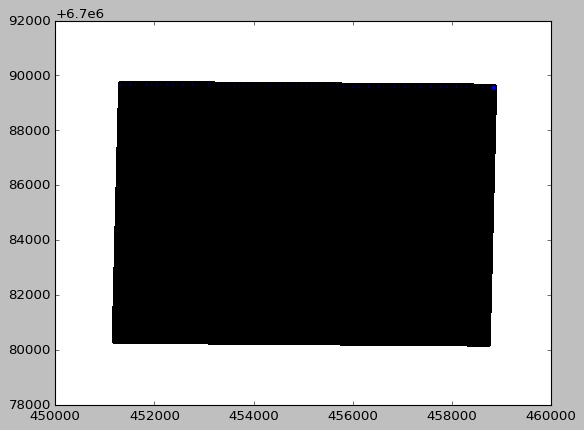

In [ ]:
# Plot the survey
plt.scatter(df.CDPX, df.CDPY)
plt.show()

## Seismic horizons

In [7]:
# Load seismic horizon data
colnames = ["A", "B", "UTM X", "UTM Y", "TWT"]

seis_creta  = np.loadtxt("/content/geostatistics/data/gullfaks/Base Cretaceous")
seis_creta  = pd.DataFrame(seis_creta, columns=colnames)

seis_etive  = np.loadtxt("/content/geostatistics/data/gullfaks/Top Etive")
seis_etive  = pd.DataFrame(seis_etive, columns=colnames)

seis_ness   = np.loadtxt("/content/geostatistics/data/gullfaks/Top Ness")
seis_ness   = pd.DataFrame(seis_ness, columns=colnames)

seis_tarb   = np.loadtxt("/content/geostatistics/data/gullfaks/Top Tarbert")
seis_tarb   = pd.DataFrame(seis_tarb, columns=colnames)

seis_ness.head()

,A,B,UTM X,UTM Y,TWT
0,0.0,0.0,453661.81,6780243.28,2009.79
1,0.0,0.0,453686.81,6780243.28,2010.79
2,0.0,0.0,453699.31,6780242.48,2006.79
3,0.0,0.0,453724.31,6780242.48,2006.79
4,0.0,0.0,453736.81,6780242.48,2002.79


## Amplitude extraction on Ness horizon

Using "Scipy.interpolate.interpn". First, we need the "coordinates" from which we want to interpolate, in form of TUPLE; coordinates of the seismic cube. Name it as "X_train".

In [17]:
# Define the min and max of value range (seismic cube)
min_xi, max_xi = df.CDPX.min(), df.CDPX.max() # Is the min and max of coordinates of the cube data
min_yi, max_yi = df.CDPY.min(), df.CDPY.max()

# Define dimension of seismic cube
nx, ny, nz = cube.data.shape

# Create array of coordinates
xi = np.linspace(min_xi, max_xi, nx)
yi = np.linspace(min_yi, max_yi, ny)
zi = cube.twt + 1397

# Make into tuple
X_train = (xi, yi, zi) # Tuple

X_train

(array([451199.        , 451219.40106952, 451239.80213904, 451260.20320856,
        451280.60427807, 451301.00534759, 451321.40641711, 451341.80748663,
        451362.20855615, 451382.60962567, 451403.01069519, 451423.41176471,
        451443.81283422, 451464.21390374, 451484.61497326, 451505.01604278,
        451525.4171123 , 451545.81818182, 451566.21925134, 451586.62032086,
        451607.02139037, 451627.42245989, 451647.82352941, 451668.22459893,
        451688.62566845, 451709.02673797, 451729.42780749, 451749.82887701,
        451770.22994652, 451790.63101604, 451811.03208556, 451831.43315508,
        451851.8342246 , 451872.23529412, 451892.63636364, 451913.03743316,
        451933.43850267, 451953.83957219, 451974.24064171, 451994.64171123,
        452015.04278075, 452035.44385027, 452055.84491979, 452076.2459893 ,
        452096.64705882, 452117.04812834, 452137.44919786, 452157.85026738,
        452178.2513369 , 452198.65240642, 452219.05347594, 452239.45454545,
        4522

Second, define "y_train" as the seismic cube. This is in 3D numpy array.

In [18]:
y_train = cube.data # 3D numpy array

y_train

array([[[ 3938.5374  ,  2153.33    ,    11.081434, ...,  1617.768   ,
          2153.33    ,  1260.7266  ],
        [ 2510.3716  ,  6259.3066  ,  8580.076   , ...,  1439.2472  ,
           725.16437 ,  -881.5222  ],
        [ -167.43929 ,  4652.62    ,  9294.159   , ...,  1082.2058  ,
          -345.96002 , -2131.1672  ],
        ...,
        [-4273.416   , -3559.333   , -2309.688   , ...,  -881.5222  ,
           903.68506 ,  3224.4546  ],
        [-6951.227   , -4987.499   , -3023.771   , ..., -2309.688   ,
         -1952.6466  ,  -345.96002 ],
        [-5166.0195  , -5523.061   , -5523.061   , ..., -3559.333   ,
         -2131.1672  ,    11.081434]],

       [[ -345.96002 , -3380.8123  , -5344.5405  , ...,  -345.96002 ,
          1260.7266  ,  1974.8094  ],
        [ 4295.579   ,  4117.058   ,  2510.3716  , ..., -1238.5636  ,
          -881.5222  ,  -881.5222  ],
        [ 4117.058   ,  6616.348   ,  7508.952   , ...,  -703.00146 ,
         -1417.0844  , -2666.7295  ],
        ...,


Next, we define the coordinates at which we want to interpolate, we name it as "X_test"; coordinates of the horizon. 

In [19]:
X_test = seis_ness[['UTM X', 'UTM Y', 'TWT']].values

X_test

array([[4.53661810e+05, 6.78024328e+06, 2.00979000e+03],
       [4.53686810e+05, 6.78024328e+06, 2.01079000e+03],
       [4.53699310e+05, 6.78024248e+06, 2.00679000e+03],
       ...,
       [4.56596350e+05, 6.78363161e+06, 1.74074400e+03],
       [4.56621350e+05, 6.78363126e+06, 1.73850400e+03],
       [4.56646350e+05, 6.78363091e+06, 1.73626300e+03]])

Finally the interpolation.

In [20]:
y_pred = interpn(X_train, y_train, X_test, bounds_error=False)

y_pred

array([           nan,            nan,            nan, ...,
       -1081.34335282,   411.7365815 , -1128.89464851])

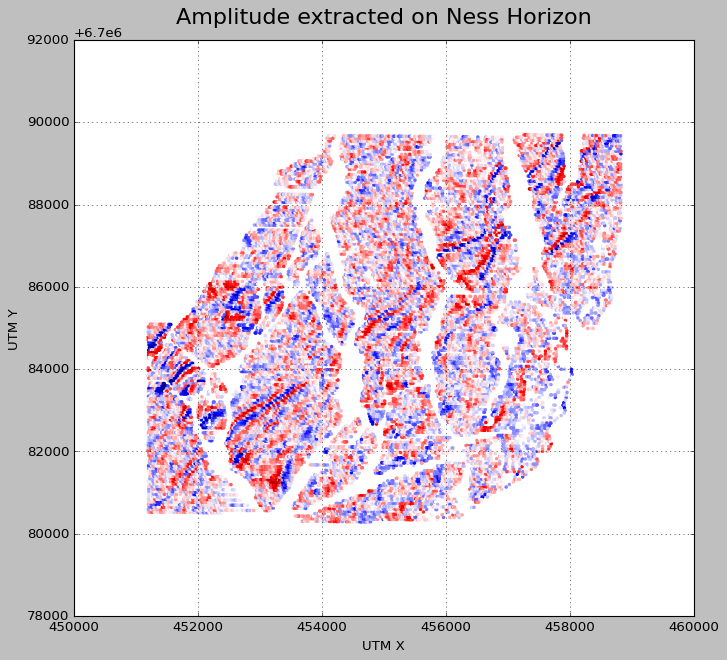

In [23]:
plt.figure(figsize=(10,9))

plt.scatter(x=seis_ness['UTM X'], y=seis_ness['UTM Y'], c=y_pred, cmap='seismic',
            linewidths=0, s=10)
plt.xlabel("UTM X"); plt.ylabel("UTM Y")
plt.title("Amplitude extracted on Ness Horizon", size=20, pad=15)

plt.grid()
plt.show()